# As-Rigid-As-Possible (ARAP) Deformation in 2D

This notebook is a step-by-step, practical introduction to ARAP surface deformation for 2D triangle meshes. You'll:
- Build a tiny 2D mesh
- Understand the ARAP energy: local and global steps
- Compute per-triangle best-fitting rotations
- Assemble and solve the global linear system with positional constraints (handles)
- Experiment with dragging handles and see the deformation

We'll keep the math minimal but precise, and provide runnable NumPy code you can extend. At the end, we map the concepts to your project code in `src/rigid_mesh_deformer.py`.

## Imports and Utilities
We use NumPy for linear algebra and Matplotlib for visualization.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from dataclasses import dataclass

np.set_printoptions(suppress=True, precision=4)

def vec2(v):
    v = np.asarray(v, dtype=np.float64)
    return v.reshape(2,)

def normalize2(v):
    n = np.linalg.norm(v)
    return v/n if n > 1e-12 else v

def edges_from_faces(F):
    # F: (M,3) triangles, returns unique undirected edges
    E = set()
    for (a,b,c) in F:
        for u, v in [(a,b),(b,c),(c,a)]:
            E.add(tuple(sorted((int(u), int(v)))))
    return np.array(sorted(list(E)), dtype=int)

def cot(a, b, c):
    # cotangent at vertex a of triangle (a,b,c)
    u = b - a
    v = c - a
    cos_ = u @ v
    sin_ = np.cross(np.append(u,0), np.append(v,0))[2]
    return cos_/sin_ if abs(sin_) > 1e-12 else 0.0

## A Tiny 2D Mesh
We'll start with a simple square domain triangulated into two triangles. We'll also compute the cotangent Laplacian (common in ARAP implementations) for the global step.

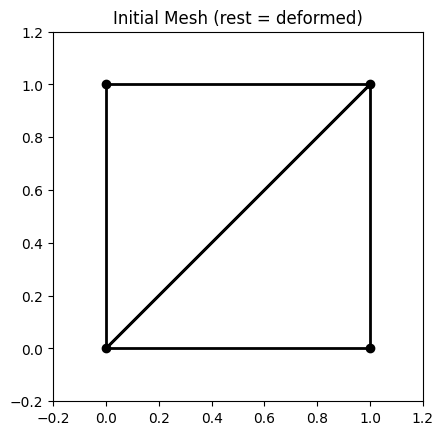

In [2]:
# Square with two triangles
V0 = np.array([
    [0.0, 0.0],  # 0
    [1.0, 0.0],  # 1
    [1.0, 1.0],  # 2
    [0.0, 1.0],  # 3
], dtype=np.float64)

F = np.array([
    [0, 1, 2],
    [0, 2, 3]
], dtype=int)

V = V0.copy()  # deformed positions start equal to rest positions

def plot_mesh(V, F, ax=None, color='k', lw=2, pts=True, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    segments = []
    for (a,b,c) in F:
        segments += [ [V[a], V[b]], [V[b], V[c]], [V[c], V[a]] ]
    lc = LineCollection(segments, colors=color, linewidths=lw)
    ax.add_collection(lc)
    if pts:
        ax.scatter(V[:,0], V[:,1], color=color)
    ax.set_aspect('equal')
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)
    if title:
        ax.set_title(title)
    return ax

ax = plot_mesh(V, F, title='Initial Mesh')
plt.show()

## ARAP Energy Overview
ARAP seeks new vertex positions V minimizing an energy that tries to preserve local rigidity while matching user constraints. For each triangle t with vertices i,j,k:
- Local step: find rotation R_t that best aligns current deformed edges to rest edges
- Global step: solve a sparse linear system that updates vertex positions to be as close as possible to the rotated rest edges while respecting constraints

We iterate Local → Global until convergence (or a few iterations suffice).

## Local Step: Best-Fitting Rotation per Triangle

SO(2) is the “special orthogonal group” in 2D: the set of all 2×2 rotation matrices with determinant +1.
* “Orthogonal” means R^T R = I (columns are orthonormal).
* “Special” means det(R) = +1 (no reflection).

In 2D, any R ∈ SO(2) has the form:

```
[ [cos θ, -sin θ],
  [sin θ,  cos θ] ]
```

for some angle θ, representing a pure rotation about the origin.

We want to minimizze || (V_i - V_j) - R_t (V0_i - V0_j) ||^2, where

* R_t ∈ SO(2)
* (V_i - V_j) edge of deformed mesh
* (V0_i - V0_j) edge of orig mesh

In practice, we can compute R_t via a 2x2 SVD of a covariance matrix:
C_t = Σ_e w_e (v_e)(v0_e)^T, where v_e are current deformed edges and v0_e are rest edges, with weights w_e (cotangent weights or uniform).

Then R_t = U diag(1, det(UV^T)) V^T, where C_t = U S V^T (SVD).

In [1]:
def triangle_edges(V, f):
    i, j, k = f
    return (V[j]-V[i], V[k]-V[j], V[i]-V[k])  # oriented edges across triangle

def best_rotation_2x2(C):
    U, S, Vt = np.linalg.svd(C)
    R = U @ Vt
    # ensure det(R)=+1
    if np.linalg.det(R) < 0:
        U[:,1] *= -1
        R = U @ Vt
    return R

def local_step(V, V0, F, edge_weight='uniform'):
    # returns list of 2x2 rotations per triangle
    R_list = []
    for f in F:
        e0 = triangle_edges(V0, f)
        e  = triangle_edges(V,  f)
        if edge_weight == 'uniform':
            w = [1.0, 1.0, 1.0]
        else:
            # simple cot weights per corner mapped to opposite edge
            i,j,k = f
            wi = max(cot(V0[i], V0[j], V0[k]), 0.0)
            wj = max(cot(V0[j], V0[k], V0[i]), 0.0)
            wk = max(cot(V0[k], V0[i], V0[j]), 0.0)
            w = [wi, wj, wk]
        C = np.zeros((2,2))
        for we, ve, v0e in zip(w, e, e0):
            C += we * np.outer(ve, v0e)
        R = best_rotation_2x2(C)
        R_list.append(R)
    return R_list

R_list = local_step(V, V0, F, edge_weight='uniform')
R_list

NameError: name 'V' is not defined

Initially, V == V0 so the best rotations are the identity (or numerically close).

## Global Step: Solve for Vertex Positions
Given R_t, we solve for V by minimizing sum of difference between edge length of deformed mesh and edge length of orig mesh, subject to position constraints. Hence the formula, w_e || (V_i - V_j) - R_t (V0_i - V0_j) ||^2,

This yields a sparse linear system: L V = B, where L is a Laplacian-like matrix and B encodes rotated rest edges. Constraints are applied by pinning rows or using soft constraints (we'll use hard constraints/pinning for clarity).

In [4]:
def build_uniform_laplacian(n, F):
    # simple graph Laplacian (uniform weights)
    E = edges_from_faces(F)
    L = np.zeros((n,n))
    for a,b in E:
        L[a,a] += 1; L[b,b] += 1
        L[a,b] -= 1; L[b,a] -= 1
    return L

def build_rhs(V0, F, R_list):
    # Each triangle contributes to B via rotated rest edges.
    # For uniform Laplacian, a common derivation yields B = sum over neighbors of rotated differences.
    n = V0.shape[0]
    B = np.zeros((n,2))
    # Accumulate contributions per triangle
    for t, f in enumerate(F):
        i,j,k = f
        R = R_list[t]
        # triangle edges in rest pose
        e_ij0 = V0[i]-V0[j]; e_jk0 = V0[j]-V0[k]; e_ki0 = V0[k]-V0[i]
        # rotated edges
        r_ij = R @ e_ij0; r_jk = R @ e_jk0; r_ki = R @ e_ki0
        # Each edge contributes to two vertices with opposite signs (uniform weights)
        B[i] += r_ij - r_ki
        B[j] += r_jk - r_ij
        B[k] += r_ki - r_jk
    return B

def apply_constraints(L, B, constraints):
    # constraints: dict {vertex_index: target_xy}
    Lc = L.copy()
    Bc = B.copy()
    for idx, pos in constraints.items():
        # zero row
        Lc[idx,:] = 0
        Lc[idx,idx] = 1
        # set rhs to target
        Bc[idx,:] = pos
    return Lc, Bc

def global_step(V, V0, F, R_list, constraints):
    n = V.shape[0]
    L = build_uniform_laplacian(n, F)
    B = build_rhs(V0, F, R_list)
    Lc, Bc = apply_constraints(L, B, constraints)
    # Solve two independent systems for x and y
    X = np.linalg.solve(Lc, Bc[:,0])
    Y = np.linalg.solve(Lc, Bc[:,1])
    return np.column_stack((X,Y))

## One ARAP Iteration
Now we can run Local → Global once. Let’s add constraints: pin the bottom-left vertex (0) and drag the top-right (2).

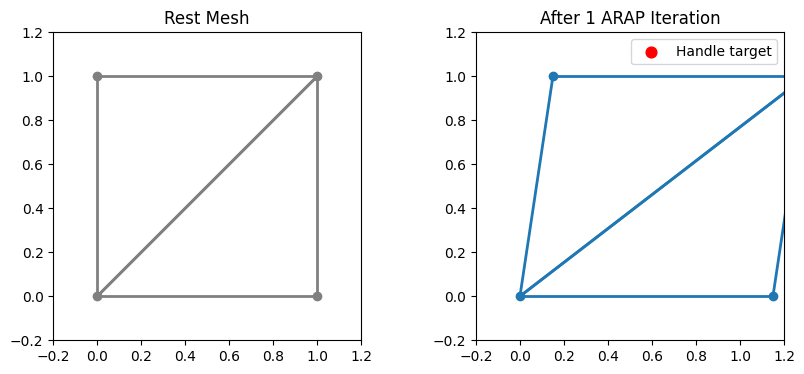

In [5]:
constraints = {
    0: V0[0],      # pin
    2: V0[2] + np.array([0.3, 0.0])  # drag to the right
}

R_list = local_step(V, V0, F)
V1 = global_step(V, V0, F, R_list, constraints)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_mesh(V0, F, ax=ax[0], color='gray', title='Rest Mesh')
plot_mesh(V1, F, ax=ax[1], color='C0', title='After 1 ARAP Iteration')
ax[1].scatter([constraints[2][0]],[constraints[2][1]], color='red', s=60, label='Handle target')
ax[1].legend()
plt.show()

V = V1.copy()  # update current positions

## Iterate a Few Times
Usually 5–10 iterations are enough for a stable result.

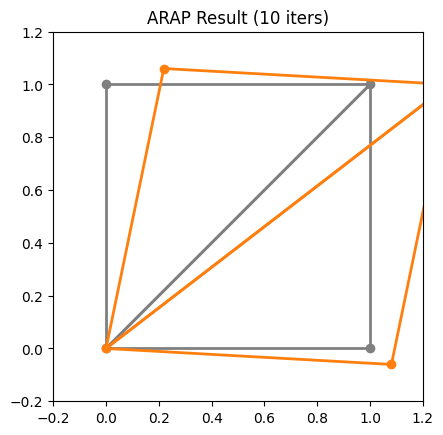

In [6]:
def arap_solve(V0, F, constraints, iters=5):
    V = V0.copy()
    for _ in range(iters):
        R_list = local_step(V, V0, F)
        V = global_step(V, V0, F, R_list, constraints)
    return V

V_arp = arap_solve(V0, F, constraints, iters=10)
ax = plot_mesh(V0, F, color='gray', title='ARAP Result (10 iters)')
plot_mesh(V_arp, F, ax=ax, color='C1')
ax.scatter([constraints[2][0]],[constraints[2][1]], color='red', s=60)
plt.show()

## Interactive Experiment (Drag a Handle)
Use the widget below to move vertex 2 around and see the deformation update. This is a minimal in-notebook analogue to your PyQt app's interactive dragging.

In [7]:
%matplotlib qt

V_current = V0.copy()
handle_idx = 2
fixed_idx = 0

fig, ax = plt.subplots()
plot_mesh(V0, F, ax=ax, color='gray', title='Drag the red handle')
mesh_line = plot_mesh(V_current, F, ax=ax, color='C0')
handle_scatter = ax.scatter([V_current[handle_idx,0]],[V_current[handle_idx,1]], color='red', s=60)
dragging = {'active': False}

def redraw():
    ax.cla()
    plot_mesh(V0, F, ax=ax, color='gray')
    plot_mesh(V_current, F, ax=ax, color='C0')
    ax.scatter([V_current[handle_idx,0]],[V_current[handle_idx,1]], color='red', s=60)
    fig.canvas.draw_idle()

def on_press(event):
    if event.inaxes != ax: return
    p = np.array([event.xdata, event.ydata])
    if np.linalg.norm(p - V_current[handle_idx]) < 0.1:
        dragging['active'] = True

def on_release(event):
    dragging['active'] = False

def on_move(event):
    if not dragging['active'] or event.inaxes != ax:
        return
    p = np.array([event.xdata, event.ydata])
    constraints = {fixed_idx: V0[fixed_idx], handle_idx: p}
    V_new = arap_solve(V0, F, constraints, iters=5)
    V_current[:] = V_new
    redraw()

cid1 = fig.canvas.mpl_connect('button_press_event', on_press)
cid2 = fig.canvas.mpl_connect('button_release_event', on_release)
cid3 = fig.canvas.mpl_connect('motion_notify_event', on_move)
redraw()

Tip: `%matplotlib qt` is used as it is faster. Do first `pip install ipympl`.

## Weights, Stability, and Variants
- Uniform vs. cotangent weights: cotangent weights (derived from mesh geometry) generally give better shape preservation.
- Hard vs. soft constraints: we pin rows here. Soft constraints can be handled by adding large weights on constraint rows.
- 2D vs. 3D: The rotation step generalizes via 2x2 vs. 3x3 SVD; the global system structure is similar.
- Pre-factorization: In interactive settings, the system matrix with pinned constraints can be factored once and reused; only the RHS changes as handles move (your app does this via LU factorization in SciPy).

## Mapping to Your Codebase
In your project:
- `src/rigid_mesh_deformer.py` holds the core ARAP logic. Look for methods analogous to:
  - Local step: computing per-triangle orientation (rotation) matrices (e.g., `precompute_orientation_matrix`, `update_scaled_triangle`) and the fitting step.
  - Global step: assembling the linear system and solving with LU (`precompute_fitting_matrices`, `apply_fitting_step`, `validate_deformed_mesh`).
- `src/deform_gl_widget.py` coordinates the mesh, constraints (handles), and calls `update_deformed_mesh` when dragging.

Key parallels with this notebook:
- Our `local_step` ~ your per-triangle rotation estimation using rest vs. current edges.
- Our `global_step` with constraints ~ your linear solve using a Laplacian-like matrix and constraints.
- Iteration loop ~ your repeated validation/update cycle during interactive dragging.

This notebook purposefully uses a small mesh and a uniform Laplacian for clarity. Your application uses more robust formulations and precomputations optimized for interactivity and arbitrary meshes.

## Next Steps
- Replace the simple square with a more complex 2D mesh (e.g., load a .obj and keep only XY).
- Switch to cotangent weights in both local and global steps for improved behavior.
- Implement pre-factorization of the system matrix for speed with moving handles.
- Extend to multiple handles and constraints.
- Compare results visually with your PyQt app by exporting intermediate states.

## Running ARAP on assets/man.obj (XY)
We'll now load the OBJ at `assets/man.obj`, extract its XY coordinates, triangulate faces (fan triangulation for polygons), and run the same ARAP loop. We'll choose two handle vertices automatically:
- Fixed: left-most vertex
- Dragged: right-most vertex (moved slightly to the right)

In [10]:
def read_obj_xy_tris(path):
    """
    Lightweight OBJ reader for 2D use:
    - Reads 'v' lines (keeps x,y; ignores z)
    - Reads 'f' lines and triangulates polygons into triangle fans
    Returns:
      Vxy: (n, 2) float64
      F:   (m, 3) int
    """
    V = []
    F = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split()
            if parts[0] == 'v':
                # vertex: v x y [z]
                x = float(parts[1]); y = float(parts[2])
                V.append([x, y])
            elif parts[0] == 'f':
                # face: f i[/..] j[/..] k[/..] ...
                idxs = []
                for t in parts[1:]:
                    s = t.split('/')[0]
                    idxs.append(int(s) - 1)  # OBJ is 1-based
                # fan triangulation if polygon
                if len(idxs) >= 3:
                    for k in range(1, len(idxs)-1):
                        F.append([idxs[0], idxs[k], idxs[k+1]])
    if len(V) == 0 or len(F) == 0:
        raise ValueError("OBJ did not contain vertices or faces.")
    return np.array(V, dtype=np.float64), np.array(F, dtype=int)

obj_path = os.path.join('../assets', 'man.obj')
V0_man, F_man = read_obj_xy_tris(obj_path)
print(f"Loaded mesh: {V0_man.shape[0]} vertices, {F_man.shape[0]} triangles")

ax = plot_mesh(V0_man, F_man, color='gray', title='assets/man.obj (XY)')
plt.show()

Loaded mesh: 214 vertices, 332 triangles


### Optional: Interactive dragging on man.obj
Drag the right-most vertex target and re-solve ARAP (runs a few iterations per move). On very large meshes, this can be slow without prefactorization.

In [11]:
### Choose handles (left-most pinned, right-most dragged)
# Identify left-most and right-most vertices in XY
left_idx = int(np.argmin(V0_man[:, 0]))
right_idx = int(np.argmax(V0_man[:, 0]))

# Create a small horizontal displacement for the right-most vertex
drag_delta = np.array([0.1 * (V0_man[:, 0].max() - V0_man[:, 0].min() + 1e-6), 0.0])
constraints_man = {
    left_idx: V0_man[left_idx],
    right_idx: V0_man[right_idx] + drag_delta
}

print("Fixed handle (left-most) index:", left_idx, "pos:", V0_man[left_idx])
print("Dragged handle (right-most) index:", right_idx, "target:", constraints_man[right_idx])

# Run a few ARAP iterations
V_man_deformed = arap_solve(V0_man, F_man, constraints_man, iters=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_mesh(V0_man, F_man, ax=ax[0], color='gray', title='Rest (man.obj)')
ax[0].scatter([V0_man[left_idx, 0]], [V0_man[left_idx, 1]], color='green', s=40, label='fixed')
ax[0].scatter([V0_man[right_idx, 0]], [V0_man[right_idx, 1]], color='orange', s=40, label='dragged (rest)')
ax[0].legend()

plot_mesh(V_man_deformed, F_man, ax=ax[1], color='C1', title='ARAP Deformed (10 iters)')
ax[1].scatter([constraints_man[right_idx][0]], [constraints_man[right_idx][1]], color='red', s=60,
              label='handle target')
ax[1].legend()
plt.show()

Fixed handle (left-most) index: 171 pos: [-0.8826  0.6158]
Dragged handle (right-most) index: 185 target: [1.1152 0.6115]


## Switch to Cotangent Weights

switch the ARAP formulation from uniform weights to cotangent weights. This improves rigidity preservation and reduces shearing on irregular meshes like assets/man.obj.

What changes:
- Add a cotangent Laplacian builder.
- Add a cotangent-weighted RHS builder consistent with the ARAP derivation.
- Update local_step to use cotangent weights.
- Provide a global_step_cot that uses the cotangent Laplacian and RHS.
- Show how to run ARAP with cotangent weights on both the square and man.obj.

### 1) Add adjacency helpers and cotangent Laplacian


In [12]:

def vertex_face_adjacency(n, F):
    vf = [[] for _ in range(n)]
    for t, (i, j, k) in enumerate(F):
        vf[i].append(t);
        vf[j].append(t);
        vf[k].append(t)
    return vf


def cotangent_laplacian(V0, F):
    """
    Symmetric cotangent Laplacian L (n x n).
    L_ij = -0.5 * (cot(alpha_ij) + cot(beta_ij)) for edge ij,
    L_ii = -sum_{j != i} L_ij
    """
    n = V0.shape[0]
    L = np.zeros((n, n), dtype=np.float64)
    for (i, j, k) in F:
        # For triangle (i,j,k), angles at i,j,k influence opposite edges
        # cot at i for angle between (j-i) and (k-i)
        cot_i = cot(V0[i], V0[j], V0[k])
        cot_j = cot(V0[j], V0[k], V0[i])
        cot_k = cot(V0[k], V0[i], V0[j])

        # Add contributions: for edge (j,k), add cot at i; etc.
        # Edge (j,k) gets cot_i
        for a, b, w in [(j, k, cot_i), (k, i, cot_j), (i, j, cot_k)]:
            L[a, b] -= 0.5 * w
            L[b, a] -= 0.5 * w
            L[a, a] += 0.5 * w
            L[b, b] += 0.5 * w
    return L

### 2) Cotangent-weighted RHS for ARAP

The cotangent-weighted ARAP global system can be written as L V = B, with L as the cotangent Laplacian. The RHS B sums, for each edge (i,j) in triangle t, the cotangent weight times the rotated rest edge (v0_i - v0_j). One consistent way:

In [13]:

def build_rhs_cot(V0, F, R_list):
    """
    Cotangent-weighted RHS consistent with ARAP:
    For each triangle t=(i,j,k) with rotation R_t, edges are (i,j), (j,k), (k,i).
    Each edge contributes w_ij * R_t * (x_i^0 - x_j^0) to vertex i
    and w_ij * R_t * (x_j^0 - x_i^0) to vertex j, where w_ij is
    the cotangent weight for edge (i,j) in this triangle (from the angle opposite that edge).
    We accumulate contributions from all incident triangles.
    """
    n = V0.shape[0]
    B = np.zeros((n, 2), dtype=np.float64)

    for t, (i, j, k) in enumerate(F):
        R = R_list[t]

        # Opposite-angle cot weights per edge
        w_ij = max(cot(V0[k], V0[i], V0[j]), 0.0)  # angle at k opposite to edge (i,j)
        w_jk = max(cot(V0[i], V0[j], V0[k]), 0.0)  # angle at i opposite to edge (j,k)
        w_ki = max(cot(V0[j], V0[k], V0[i]), 0.0)  # angle at j opposite to edge (k,i)

        # Rest-space edges
        e_ij0 = V0[i] - V0[j]
        e_jk0 = V0[j] - V0[k]
        e_ki0 = V0[k] - V0[i]

        # Rotated edges
        r_ij = R @ e_ij0
        r_jk = R @ e_jk0
        r_ki = R @ e_ki0

        # Accumulate symmetric contributions
        B[i] += w_ij * r_ij - w_ki * r_ki
        B[j] += w_jk * r_jk - w_ij * r_ij
        B[k] += w_ki * r_ki - w_jk * r_jk

    return B

### 3) Local step with cotangent weights

Swap the local rotation estimate to use cotangent weights by passing edge_weight='cot' (we already added this option in local_step). If not present, add the branch as shown below:

```python
# File: D:/ProgrammingPython/ZGL Projects/deform2d/arap.ipynb
##%%

# local_step already contains edge_weight parameter. Ensure the 'cot' branch exists:
# if edge_weight == 'uniform': ...
# else: uses wi, wj, wk from cot(...) calls
# Nothing else to change here if your notebook already has the 'else' that computes cot weights.
```

### 4) Constraint application stays the same

We can reuse apply_constraints.

### 5) Global step (cotangent)

Provide a separate function so you can easily switch between uniform and cot versions:

In [14]:
# Provide a separate function so you can easily switch between uniform and cot versions:
def global_step_cot(V, V0, F, R_list, constraints):
    L = cotangent_laplacian(V0, F)
    B = build_rhs_cot(V0, F, R_list)
    Lc, Bc = apply_constraints(L, B, constraints)
    X = np.linalg.solve(Lc, Bc[:, 0])
    Y = np.linalg.solve(Lc, Bc[:, 1])
    return np.column_stack((X, Y))

### 6) A convenience ARAP solver using cotangent weights

In [15]:

def arap_solve_cot(V0, F, constraints, iters=5):
    V = V0.copy()
    for _ in range(iters):
        R_list = local_step(V, V0, F, edge_weight='cot')
        V = global_step_cot(V, V0, F, R_list, constraints)
    return V

### 7) Use it on the square mesh and man.obj

Example for the square:


In [16]:

constraints_square = {0: V0[0], 2: V0[2] + np.array([0.3, 0.0])}
V_arp_cot = arap_solve_cot(V0, F, constraints_square, iters=10)

ax = plot_mesh(V0, F, color='gray', title='ARAP (cotangent weights) — Square')
plot_mesh(V_arp_cot, F, ax=ax, color='C2')
ax.scatter([constraints_square[2][0]], [constraints_square[2][1]], color='red', s=60)
plt.show()

<IPython.core.display.Javascript object>

And for man.obj (reusing left_idx, right_idx, drag_delta defined earlier):

In [17]:

constraints_man_cot = {
    left_idx: V0_man[left_idx],
    right_idx: V0_man[right_idx] + drag_delta
}
V_man_deformed_cot = arap_solve_cot(V0_man, F_man, constraints_man_cot, iters=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_mesh(V0_man, F_man, ax=ax[0], color='gray', title='Rest (man.obj)')
ax[0].scatter([V0_man[left_idx, 0]], [V0_man[left_idx, 1]], color='green', s=40, label='fixed')
ax[0].scatter([V0_man[right_idx, 0]], [V0_man[right_idx, 1]], color='orange', s=40, label='dragged (rest)')
ax[0].legend()

plot_mesh(V_man_deformed_cot, F_man, ax=ax[1], color='C2', title='ARAP (cot weights) Deformed (10 iters)')
ax[1].scatter([constraints_man_cot[right_idx][0]], [constraints_man_cot[right_idx][1]], color='red', s=60,
              label='handle target')
ax[1].legend()
plt.show()

<IPython.core.display.Javascript object>

### 8) Optional: make the interactive demo use cotangent weights

Replace arap_solve with arap_solve_cot in the motion handler:

In [18]:

def on_move_man(event):
    global target
    if not dragging['active'] or event.inaxes != ax:
        return
    target = np.array([event.xdata, event.ydata])
    cons = {fixed_idx: V0_man[fixed_idx], handle_idx: target}
    V_new = arap_solve_cot(V0_man, F_man, cons, iters=5)  # switched to cot
    V_current_man[:] = V_new
    redraw_man()

## Summary of what you get
- More stable and shape-preserving deformations on irregular meshes.
- Same interface: constraints and iterations remain the same.
- You can easily toggle between uniform and cotangent approaches by calling arap_solve vs. arap_solve_cot.

## Pre-factor the cotangent system matrix

Pre-factor the cotangent system matrix once and reuse the factorization for every drag update. This makes interactive dragging much faster because only the RHS changes when the handle moves.

What we’ll do
- Build the cotangent Laplacian L once (from rest V0 and faces F).
- Impose hard constraints by row-pinning into a modified matrix Lc (we must know the fixed/handle indices to pin).
- LU-factor Lc once.
- During dragging, rebuild only the RHS Bc from the current handle target and solve via the prefactorization.

### 1) Add a small utility to build the constrained system matrix Lc and an LU factorization function

In [19]:
import scipy.linalg as sla


def build_constrained_system(L, constraints):
    """
    Returns a copy Lc of L with hard constraints imposed by row pinning:
    For each constrained vertex i, zero the row and set Lc[i,i] = 1.
    Note: We do not modify columns; RHS will be set to target positions.
    """
    Lc = L.copy()
    for idx in constraints.keys():
        Lc[idx, :] = 0.0
        Lc[idx, idx] = 1.0
    return Lc


def lu_factorize(A):
    """
    LU factorization wrapper (SciPy) for reuse across solves.
    """
    return sla.lu_factor(A, check_finite=False)


def lu_solve_factor(lu_piv, b):
    """
    Solve A x = b given lu_piv from lu_factorize(A).
    """
    return sla.lu_solve(lu_piv, b, check_finite=False)

### 2) Prefactorized cotangent ARAP global step
- This variant expects:
  - A fixed factorization of the constrained L (Lc) for the current set of constrained indices.
  - On each iteration, we recompute rotations and the cotangent RHS B from rest geometry and current V.
  - We then set Bc at constrained rows to the target positions and solve using the LU factors.

In [20]:
def global_step_cot_prefact(V, V0, F, R_list, constraints, Lc_lu):
    """
    Use pre-factorized constrained cotangent Laplacian:
    - L is fixed (from V0 and F)
    - Constraints indices are fixed; only RHS changes
    """
    # Build cotangent RHS from rotations
    B = build_rhs_cot(V0, F, R_list)
    # Apply constraints to RHS only (rows were pinned in Lc already)
    Bc = B.copy()
    for idx, pos in constraints.items():
        Bc[idx, :] = pos
    # Solve two independent systems with LU factors
    X = lu_solve_factor(Lc_lu, Bc[:, 0])
    Y = lu_solve_factor(Lc_lu, Bc[:, 1])
    return np.column_stack((X, Y))

### 3) A solver that reuses the prefactorization across ARAP iterations
- The constraints set is assumed fixed during the solve (index set doesn’t change inside this routine).

In [21]:
def arap_solve_cot_prefact(V0, F, constraints, Lc_lu, iters=5):
    """
    ARAP loop using cotangent weights with pre-factorized constrained system matrix.
    The LU factor Lc_lu corresponds to build_constrained_system(cotangent_laplacian(V0,F), constraints).
    """
    V = V0.copy()
    for _ in range(iters):
        R_list = local_step(V, V0, F, edge_weight='cot')
        V = global_step_cot_prefact(V, V0, F, R_list, constraints, Lc_lu)
    return V

### 4) Precompute and factor Lc for man.obj once, then use it in the interactive dragging
- Build L from V0_man and F_man once.
- Construct constraints dict with fixed_idx and handle_idx (for interactive we’ll change only the handle’s target position, not indices).
- Build Lc and factor it once.
- Switch on_move_man to reuse Lc_lu.

Insert these where you set up the interactive demo for man.obj (after you define left_idx, right_idx, etc.):

In [22]:
# Precompute cotangent Laplacian at rest
L_cot_man = cotangent_laplacian(V0_man, F_man)

# For interactive use, the constrained index set must be fixed to reuse Lc.
# We'll constrain: fixed_idx (left-most) and handle_idx (right-most).
fixed_idx = left_idx
handle_idx = right_idx

# We won't set the handle target value here (it changes during drag), just the indices.
constraints_indices = {fixed_idx: V0_man[fixed_idx], handle_idx: V0_man[handle_idx]}

# Build constrained system and factorize once
Lc_man = build_constrained_system(L_cot_man, constraints_indices)
Lc_lu_man = lu_factorize(Lc_man)

Now update your interactive callbacks to use the prefactorized solver:

Replace your existing on_move_man with this version that uses arap_solve_cot_prefact:

In [23]:
def on_move_man(event):
    global target
    if not dragging['active'] or event.inaxes != ax:
        return
    target = np.array([event.xdata, event.ydata])
    # Only target changes; indices fixed, so we can reuse Lc_lu_man
    cons = {fixed_idx: V0_man[fixed_idx], handle_idx: target}
    V_new = arap_solve_cot_prefact(V0_man, F_man, cons, Lc_lu_man, iters=5)
    V_current_man[:] = V_new
    redraw_man()

### 5) Optional: also use prefactorization for the non-interactive run on man.obj
If you’d like the “static” solve to use the same prefactorization:

In [24]:
constraints_man_cot = {
    left_idx: V0_man[left_idx],
    right_idx: V0_man[right_idx] + drag_delta
}
# Reuse indices but change the right handle target; factor still valid:
V_man_deformed_cot_fast = arap_solve_cot_prefact(V0_man, F_man, constraints_man_cot, Lc_lu_man, iters=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_mesh(V0_man, F_man, ax=ax[0], color='gray', title='Rest (man.obj)')
ax[0].scatter([V0_man[left_idx, 0]], [V0_man[left_idx, 1]], color='green', s=40, label='fixed')
ax[0].scatter([V0_man[right_idx, 0]], [V0_man[right_idx, 1]], color='orange', s=40, label='dragged (rest)')
ax[0].legend()

plot_mesh(V_man_deformed_cot_fast, F_man, ax=ax[1], color='C2', title='ARAP (cot, prefactored) — 10 iters')
ax[1].scatter([constraints_man_cot[right_idx][0]], [constraints_man_cot[right_idx][1]], color='red', s=60,
              label='handle target')
ax[1].legend()
plt.show()

<IPython.core.display.Javascript object>

### Important notes
- Prefactorization requires a fixed set of constrained indices. During a single drag session, we keep the same fixed_idx and handle_idx; only the handle target position changes. If you add/remove handles or change which vertex indices are constrained, rebuild Lc and refactor.
- Using the rest-geometry cotangent Laplacian is standard in ARAP. If you change V0 (rest), rebuild L.
- This mirrors your PyQt app’s approach in src/rigid_mesh_deformer.py, where LU factors are cached and only RHS changes as handles move.m


## Extend to multiple handles and constraints.

Support any number of handles/constraints with the prefactored cotangent solver. The key is: the constrained index set must be fixed while reusing a factorization. You can still update the target positions at those indices every drag.

### 1) Helper to build constraints dict from a list of constrained indices
Use this to construct constraints quickly for any number of handles.

In [25]:
def constraints_from_indices(indices, V_targets):
    """
    Build a constraints dict from:
      indices: iterable of vertex indices to constrain
      V_targets: (n,2) array of target positions, where only rows at 'indices' are used.
    Returns: dict {idx: V_targets[idx]}
    """
    return {int(i): np.asarray(V_targets[int(i)], dtype=np.float64) for i in indices}

### 2) Build a prefactorization for an arbitrary fixed set of constrained indices
You can now choose any set of indices to constrain (e.g., multiple fixed pins and multiple draggable handles). Factor once, reuse for RHS updates.

In [26]:
# Example: choose multiple handles on man.obj
# - Fixed/pinned: left-most vertex + one more (e.g., lowest y)
# - Dragged handles: right-most vertex + top-most vertex
left_idx = int(np.argmin(V0_man[:, 0]))
low_idx = int(np.argmin(V0_man[:, 1]))
right_idx = int(np.argmax(V0_man[:, 0]))
top_idx = int(np.argmax(V0_man[:, 1]))

fixed_indices = [left_idx, low_idx]  # always pinned to their rest positions (or custom targets)
draggable_indices = [right_idx, top_idx]  # will move during demo

all_constrained_indices = fixed_indices + draggable_indices

# Precompute Laplacian and prefactor with the index set fixed
L_cot_man_multi = cotangent_laplacian(V0_man, F_man)
# Build a dummy constraints dict just to pin rows for factorization (values are placeholders)
dummy_constraints_multi = {i: V0_man[i] for i in all_constrained_indices}
Lc_man_multi = build_constrained_system(L_cot_man_multi, dummy_constraints_multi)
Lc_lu_man_multi = lu_factorize(Lc_man_multi)

### 3) Static solve with multiple handles
Provide specific target positions for any subset of the constrained indices (others can remain at rest or also be moved). Then solve using the same prefactorization.

In [27]:
# Example targets:
# - Fix 'fixed_indices' at rest positions
# - Move 'right_idx' slightly right; move 'top_idx' slightly up
span_x = (V0_man[:, 0].max() - V0_man[:, 0].min() + 1e-6)
span_y = (V0_man[:, 1].max() - V0_man[:, 1].min() + 1e-6)

targets_multi = V0_man.copy()
targets_multi[right_idx] = V0_man[right_idx] + np.array([0.1 * span_x, 0.0])
targets_multi[top_idx] = V0_man[top_idx] + np.array([0.0, 0.1 * span_y])

constraints_multi = constraints_from_indices(all_constrained_indices, targets_multi)

V_man_deformed_multi = arap_solve_cot_prefact(V0_man, F_man, constraints_multi, Lc_lu_man_multi, iters=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_mesh(V0_man, F_man, ax=ax[0], color='gray', title='Rest (man.obj)')
ax[0].scatter(V0_man[fixed_indices, 0], V0_man[fixed_indices, 1], color='green', s=40, label='fixed')
ax[0].scatter(V0_man[draggable_indices, 0], V0_man[draggable_indices, 1], color='orange', s=40, label='dragged (rest)')
ax[0].legend()

plot_mesh(V_man_deformed_multi, F_man, ax=ax[1], color='C3', title='ARAP (cot, multiple handles) — 10 iters')
ax[1].scatter(targets_multi[draggable_indices, 0], targets_multi[draggable_indices, 1],
              color='red', s=60, label='handle targets')
ax[1].legend()
plt.show()

<IPython.core.display.Javascript object>

### 4) Interactive multi-handle dragging (drag any of the draggable handles)
This example lets you drag either of the chosen draggable handles (right_idx, top_idx). It keeps the fixed set of constrained indices identical, so the same LU factorization is reused. Only the target positions in constraints_multi change per mouse move.


In [28]:
%matplotlib qt

V_current_man = V0_man.copy()
current_targets = V0_man.copy()  # start at rest
# Initialize current targets for draggable handles
current_targets[right_idx] = V0_man[right_idx] + np.array([0.1 * span_x, 0.0])
current_targets[top_idx] = V0_man[top_idx] + np.array([0.0, 0.1 * span_y])

fig, ax = plt.subplots()
plot_mesh(V0_man, F_man, ax=ax, color='gray', title='Drag the orange handle targets (multi)')
plot_mesh(V_current_man, F_man, ax=ax, color='C0')
fixed_pts = ax.scatter(V0_man[fixed_indices, 0], V0_man[fixed_indices, 1], color='green', s=40, label='fixed')
target_pts = ax.scatter(current_targets[draggable_indices, 0], current_targets[draggable_indices, 1],
                        color='orange', s=60, label='targets')
dragging = {'active': False, 'which': None}


def redraw_man_multi():
    ax.cla()
    plot_mesh(V0_man, F_man, ax=ax, color='gray')
    plot_mesh(V_current_man, F_man, ax=ax, color='C0')
    ax.scatter(V0_man[fixed_indices, 0], V0_man[fixed_indices, 1], color='green', s=40)
    ax.scatter(current_targets[draggable_indices, 0], current_targets[draggable_indices, 1], color='orange', s=60)
    ax.set_title('Drag the orange handle targets (multi)')
    fig.canvas.draw_idle()


def nearest_draggable_handle(p):
    # Returns index in draggable_indices array (0..len-1) of closest handle target, or None
    pts = current_targets[draggable_indices]
    d = np.linalg.norm(pts - p, axis=1)
    k = np.argmin(d)
    if d[k] < 0.05:  # pick radius
        return int(draggable_indices[k])
    return None


def on_press_man_multi(event):
    if event.inaxes != ax: return
    p = np.array([event.xdata, event.ydata])
    which = nearest_draggable_handle(p)
    if which is not None:
        dragging['active'] = True
        dragging['which'] = which


def on_release_man_multi(event):
    dragging['active'] = False
    dragging['which'] = None


def on_move_man_multi(event):
    if not dragging['active'] or event.inaxes != ax:
        return
    p = np.array([event.xdata, event.ydata])
    h = dragging['which']
    # Update just that handle target
    current_targets[h] = p

    # Build constraints for all constrained indices using current targets
    cons = constraints_from_indices(all_constrained_indices, current_targets)
    V_new = arap_solve_cot_prefact(V0_man, F_man, cons, Lc_lu_man_multi, iters=5)
    V_current_man[:] = V_new
    redraw_man_multi()


cid1 = fig.canvas.mpl_connect('button_press_event', on_press_man_multi)
cid2 = fig.canvas.mpl_connect('button_release_event', on_release_man_multi)
cid3 = fig.canvas.mpl_connect('motion_notify_event', on_move_man_multi)
redraw_man_multi()

<IPython.core.display.Javascript object>

### Notes and tips
- The LU factorization is valid as long as the set of constrained indices stays the same. If you add/remove handles or switch which vertices are constrained, rebuild Lc and refactor using the same utilities shown above.
- Targets for any constrained index can change freely per frame; only the RHS is updated.
- You can mix “fixed” pins and “dragged” handles; both are simply entries in the constraints dict.

This pattern mirrors your app’s approach: once handles are selected (index set fixed), reuse the LU factors during dragging, recomputing only rotations and the RHS.